In [ ]:
# Import libraries
import numpy as np
import math
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
from itertools import product
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import regularizers 
from tensorflow.keras.optimizers import Adam
from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from tensorflow import optimizers
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')


In [ ]:
!pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-555fe1dc-7347-4d45-953b-09d30d660229/bin/python -m pip install --upgrade pip' command.


In [ ]:
df = pd.read_excel("./data/demand_data.xlsx")
df = df.dropna()

In [ ]:
df

,일자,3호선_전력량,3호선_승하차,평균_상대습도,평균_증기압,평균기온
0,2018-01-01,31807.588235,48202.0,32.0,2.3,2.7
1,2018-01-02,34017.529412,95106.0,39.6,3.2,4.1
2,2018-01-03,35182.411765,98250.0,24.5,1.8,2.6
3,2018-01-04,34526.470588,96098.0,38.3,3.0,2.8
4,2018-01-05,33099.705882,101421.0,46.6,3.6,4.1
...,...,...,...,...,...,...
1820,2022-12-26,32225.735294,96185.0,31.8,2.6,3.8
1821,2022-12-27,33037.941176,99303.0,47.1,2.5,2.9
1822,2022-12-28,32346.176471,92875.0,46.1,3.6,1.8
1823,2022-12-29,33014.264706,94979.0,52.5,3.2,2.4


In [ ]:
# '3호선_전력량' 컬럼에 대한 ADF 테스트 수행
result = adfuller(df['3호선_전력량'])

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# p-value 해석
if result[1] <= 0.05:
    print("데이터가 정상 시계열로 판단됩니다. (p-value <= 0.05)")
else:
    print("데이터가 비정상 시계열로 판단됩니다. (p-value > 0.05)")

ADF Statistic: -3.9578886784337506
p-value: 0.0016478014176223835
Critical Values: {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}
데이터가 정상 시계열로 판단됩니다. (p-value <= 0.05)


In [ ]:
# '3호선_전력량' 컬럼에 대한 ADF 테스트 수행
result = adfuller(df['평균_증기압'])

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# p-value 해석
if result[1] <= 0.05:
    print("데이터가 정상 시계열로 판단됩니다. (p-value <= 0.05)")
else:
    print("데이터가 비정상 시계열로 판단됩니다. (p-value > 0.05)")

ADF Statistic: -2.353882940533113
p-value: 0.1551777038516679
Critical Values: {'1%': -3.4339640110318004, '5%': -2.8631363845692475, '10%': -2.567619862152732}
데이터가 비정상 시계열로 판단됩니다. (p-value > 0.05)


In [ ]:
names = cycle(['3호선_전력량'])

fig = px.line(df, x=df.일자, y=[df['3호선_전력량']],
             labels={'date': 'Date','value':'Price'})
fig.update_layout(title_text='3호선_전력량', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
names = cycle(['평균_증기압'])

fig = px.line(df, x=df.일자, y=[df['평균_증기압']],
             labels={'date': 'Date','value':'Price'})
fig.update_layout(title_text='평균_증기압', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
# 이상치를 평균값으로 대체하는 함수
def replace_outliers_with_mean(df, column_list):
    for column in column_list:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 찾기
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # 평균값 계산 (이상치 제외)
        mean_val = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column].mean()
        
        # 이상치를 평균값으로 대체
        df[column] = df[column].apply(lambda x: mean_val if x < lower_bound or x > upper_bound else x)
        
        # 이상치 위치와 개수 출력
        print(f"{column} 컬럼의 이상치 개수: {len(outliers)}")
        print("이상치 위치:", outliers.index.tolist())
    
    return df

# 이상치를 대체할 컬럼 목록
outlier_columns = ['3호선_전력량', '평균_증기압']

# 이상치를 평균값으로 대체
df = replace_outliers_with_mean(df, outlier_columns)

3호선_전력량 컬럼의 이상치 개수: 55
이상치 위치: [24, 25, 29, 200, 201, 205, 211, 212, 215, 216, 219, 220, 221, 227, 233, 340, 360, 567, 568, 571, 574, 575, 576, 578, 581, 583, 596, 597, 598, 599, 616, 617, 618, 955, 961, 1288, 1295, 1297, 1298, 1306, 1317, 1318, 1319, 1331, 1332, 1333, 1460, 1638, 1639, 1642, 1650, 1652, 1653, 1663, 1694]
평균_증기압 컬럼의 이상치 개수: 0
이상치 위치: []


In [ ]:
# 필요한 컬럼만 추출
input_data = df[['일자','3호선_전력량','평균_증기압']].copy()

# '일자' 열을 datetime 형식으로 변환
input_data['일자'] = pd.to_datetime(input_data['일자'])

# 불필요한 '일자' 열을 제거
input_data = input_data.drop('일자', axis=1)

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(input_data)

In [ ]:
# 시계열 데이터 구조 변환 함수
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
# 시계열 데이터로 변환
time_steps = 7
X, y = create_dataset(data_scaled, data_scaled[:, 0], time_steps)
print(X.shape, y.shape)

(1818, 7, 2) (1818,)


In [ ]:
# 데이터를 학습 세트와 검증 세트로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
model=Sequential()
model.add(LSTM(16 ,return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(32 ,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16 ))
model.add(Dense(1))
model.compile(loss='mse',optimizer=Adam(learning_rate=0.01))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(X,y,epochs=100,batch_size=4, validation_data=(X_val, y_val), verbose=1, callbacks=[callback])

Epoch 1/100
  6/455 [..............................] - ETA: 4s - loss: 0.0698   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0102s vs `on_train_batch_end` time: 0.0221s). Check your callbacks.


455/455 [==============================] - 12s 15ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 2/100
455/455 [==============================] - 4s 10ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 3/100
211/455 [============>.................] - ETA: 2s - loss: 0.0077

*** WARNING: max output size exceeded, skipping output. ***

455/455 [==============================] - 5s 12ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 99/100
455/455 [==============================] - 6s 13ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 100/100
1/1 [==============================] - 1s 1s/step


INFO:tensorflow:Assets written to: /tmp/tmpmonqpn2f/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpmonqpn2f/model/data/model/assets


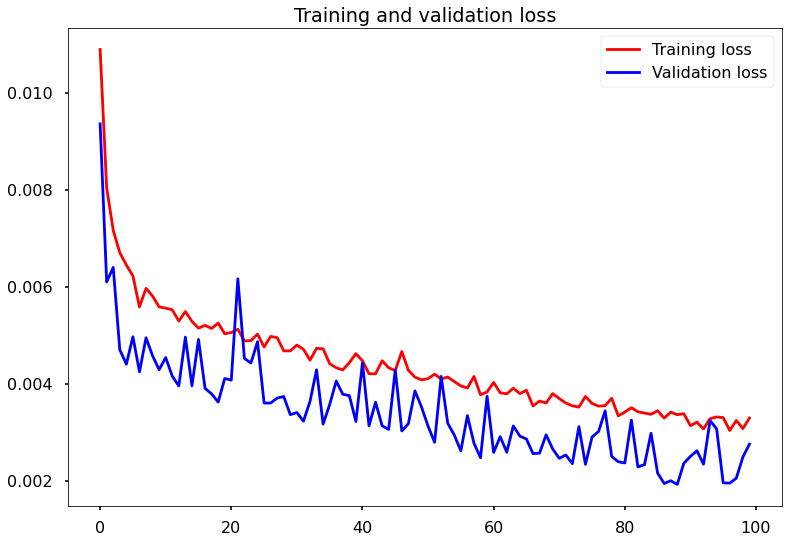

<Figure size 921.6x633.6 with 0 Axes>

In [ ]:

# import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_val)
train_predict.shape, test_predict.shape

18/18 [==============================] - 0s 4ms/step
Out[32]: ((1272, 1), (546, 1))

In [ ]:
input_data_with_date = df[['일자','3호선_전력량','평균_증기압']].copy()
# '일자' 열을 datetime 형식으로 변환
input_data_with_date['일자'] = pd.to_datetime(input_data_with_date['일자'])
input_data_with_date

,일자,3호선_전력량,평균_증기압
0,2018-01-01,31807.588235,2.3
1,2018-01-02,34017.529412,3.2
2,2018-01-03,35182.411765,1.8
3,2018-01-04,34526.470588,3.0
4,2018-01-05,33099.705882,3.6
...,...,...,...
1820,2022-12-26,32225.735294,2.6
1821,2022-12-27,33037.941176,2.5
1822,2022-12-28,32346.176471,3.6
1823,2022-12-29,33014.264706,3.2


In [ ]:
# 정규화된 예측값을 원래 스케일로 변환
train_predict_original = scaler.inverse_transform(np.hstack((train_predict, np.zeros_like(train_predict))))
test_predict_original = scaler.inverse_transform(np.hstack((test_predict, np.zeros_like(test_predict))))


In [ ]:
# shift train predictions for plotting
look_back = 7
trainPredictPlot = np.empty_like(input_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_original)+look_back, :] = train_predict_original

print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(input_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_original)+(look_back):len(input_data), :] = test_predict_original
print("Test predicted data: ", testPredictPlot.shape)

# Plotting
names = cycle(['Original 3호선 전력량','Train predicted 3호선 전력량','Test predicted 3호선 전력량'])
plotdf = pd.DataFrame({
    'date': input_data_with_date['일자'],
    'original_3호선_전력량': input_data_with_date['3호선_전력량'],
    'train_predicted_3호선_전력량': trainPredictPlot[:, 0],
    'test_predicted_3호선_전력량': testPredictPlot[:, 0]
})

fig = px.line(plotdf, x='date', y=['original_3호선_전력량', 'train_predicted_3호선_전력량', 'test_predicted_3호선_전력량'])
fig.update_layout(title_text='3호전력량+평균_증기압 3호선 전력량',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='3호선 전력량')
fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


Train predicted data:  (1825, 2)
Test predicted data:  (1825, 2)


In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# 실제 값과 예측 값을 numpy 배열로 변환
y_true = np.array(y_val)
y_pred = model.predict(X_val)

# 역정규화 (선택 사항)
# 만약 데이터를 정규화했다면, 성능 지표를 계산하기 전에 역정규화를 해야 할 수 있습니다.
# y_true_original = scaler.inverse_transform(y_true)
# y_pred_original = scaler.inverse_transform(y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print('Mean Squared Error (MSE):', mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# R-squared (결정 계수)
r2 = r2_score(y_true, y_pred)
print('R-squared:', r2)

18/18 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 0.0383393466149606
Mean Squared Error (MSE): 0.0027523575751207253
Root Mean Squared Error (RMSE): 0.05246291618963556
R-squared: 0.8878391438682636
